In [13]:
import numpy as np
from pymc3 import *
import matplotlib.pyplot as plt
%matplotlib inline

# Introduction
This notebook rewrites Abraham Flaxman's PyMC2.6 solution to [this question from StackOverflow StackOverflow](http://stackoverflow.com/questions/24804298/fit-a-function-to-data-observations-pymcmc-pymc) in PyMC3. The original notebook can be found [here](http://nbviewer.jupyter.org/gist/aflaxman/d4b1ce53b0817a1b7a71). As will be seen when comparing the two, the only difference would be the PyMC3 commands and my comments.

This question deals with fitting models that have measurement errors, both in x and y, and in order to keep things brief here, I recommend that you read the background in the links above.

# Modelling measurement error in y


First, we generate some data:

In [14]:
# set random seed for reproducibility
np.random.seed(12345)

x = np.arange(5,400,10)*1e3

# Parameters for gaussian
amp_true = 0.2
size_true = 1.8
ps_true = 0.1

#Gaussian function
gauss = lambda x,amp,size,ps: amp*np.exp(-1*(np.pi**2/(3600.*180.)*size*x)**2/(4.*np.log(2.)))+ps
f_true = gauss(x=x,amp=amp_true, size=size_true, ps=ps_true )

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
f = f_true + noise 
f_error = np.ones_like(f_true)*0.05*f.max()

Now the model structure in PyMC3 is slightly different to PyMC2.6. The most noticeable difference is that the Deterministic decorator has been replaced by a distribution-like call.

In [16]:
with Model() as model3:
    amp = Uniform('amp', 0.05, 0.4, testval= 0.15)
    size = Uniform('size', 0.5, 2.5, testval= 1.0)
    ps = Normal('ps', 0.13, 40, testval=0.15)
    
    gauss=Deterministic('gauss',amp*np.exp(-1*(np.pi**2*size*x/(3600.*180.))**2/(4.*np.log(2.)))+ps)
    
    y =Normal('y', mu=gauss, tau=1.0/f_error**2, observed=f)
    
    start=find_MAP()
    step=NUTS()
    trace=sample(2000,start=start)

Applied interval-transform to amp and added transformed amp_interval to model.
Applied interval-transform to size and added transformed size_interval to model.
Assigned NUTS to amp_interval
Assigned NUTS to size_interval
Assigned NUTS to ps
 [-----------------100%-----------------] 2000 of 2000 complete in 8.8 sec

We now do a traceplot to check how the MCMC went, and it seems fine:

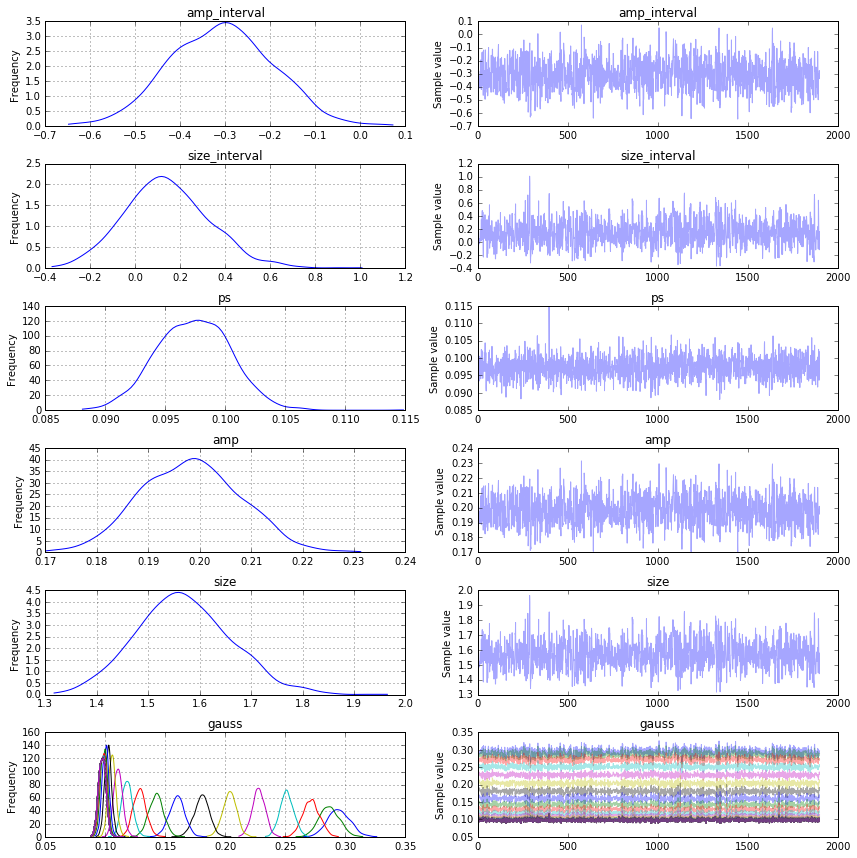

In [17]:
traceplot(trace[100:])
plt.tight_layout();

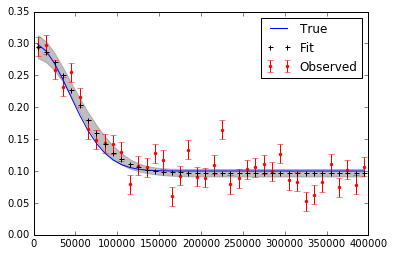

In [18]:
# extract and plot results
y_min = np.percentile(trace.gauss,2.5,axis=0)
y_max = np.percentile(trace.gauss,97.5,axis=0)
y_fit = np.percentile(trace.gauss,50,axis=0)
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x,y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x, y_min, y_max, color='0.5', alpha=0.5)
plt.legend()

## Errors in the measurement of x

I've distinguished this from the model above by adding an x as a suffix to the similarly named variables. 

Note also that the PyMC2.6 command

`x_obsx = rnormal(mu=x, tau=(1e4)**-2)`

has been replaced by

`x_obsx = Normal('x_obsx', mu=x, tau=(1e4)**-2,shape=40).random()`

In [24]:
# define the model/function to be fitted in PyMC3:
with Model() as modelx:
    
    x_obsx = pm3.Normal('x_obsx',mu=x, tau=(1e4)**-2,shape=40).random()
    #x_obsx = np.random.normal(loc=x, scale=(1e4))
    
    ampx = Uniform('ampx', 0.05, 0.4, testval= 0.15)
    sizex = Uniform('sizex', 0.5, 2.5, testval= 1.0)
    psx = Normal('psx', 0.13, 40, testval=0.15)
    
    x_pred = Normal('x_pred', mu=x_obsx, tau=(1e4)**-2*np.ones_like(x_obsx),testval=5*np.ones_like(x_obsx),shape=40) # this allows error in x_obs

    gauss=Deterministic('gauss',ampx*np.exp(-1*(np.pi**2*sizex*x_pred/(3600.*180.))**2/(4.*np.log(2.)))+psx)
    
    y = Normal('y', mu=gauss, tau=1.0/f_error**2, observed=f)
    
    start=find_MAP()
    step=NUTS()
    tracex=sample(20000,start=start)

Applied interval-transform to ampx and added transformed ampx_interval to model.
Applied interval-transform to sizex and added transformed sizex_interval to model.
Assigned NUTS to x_obsx
Assigned NUTS to ampx_interval
Assigned NUTS to sizex_interval
Assigned NUTS to psx
Assigned NUTS to x_pred
 [-----------------100%-----------------] 20000 of 20000 complete in 573.3 sec

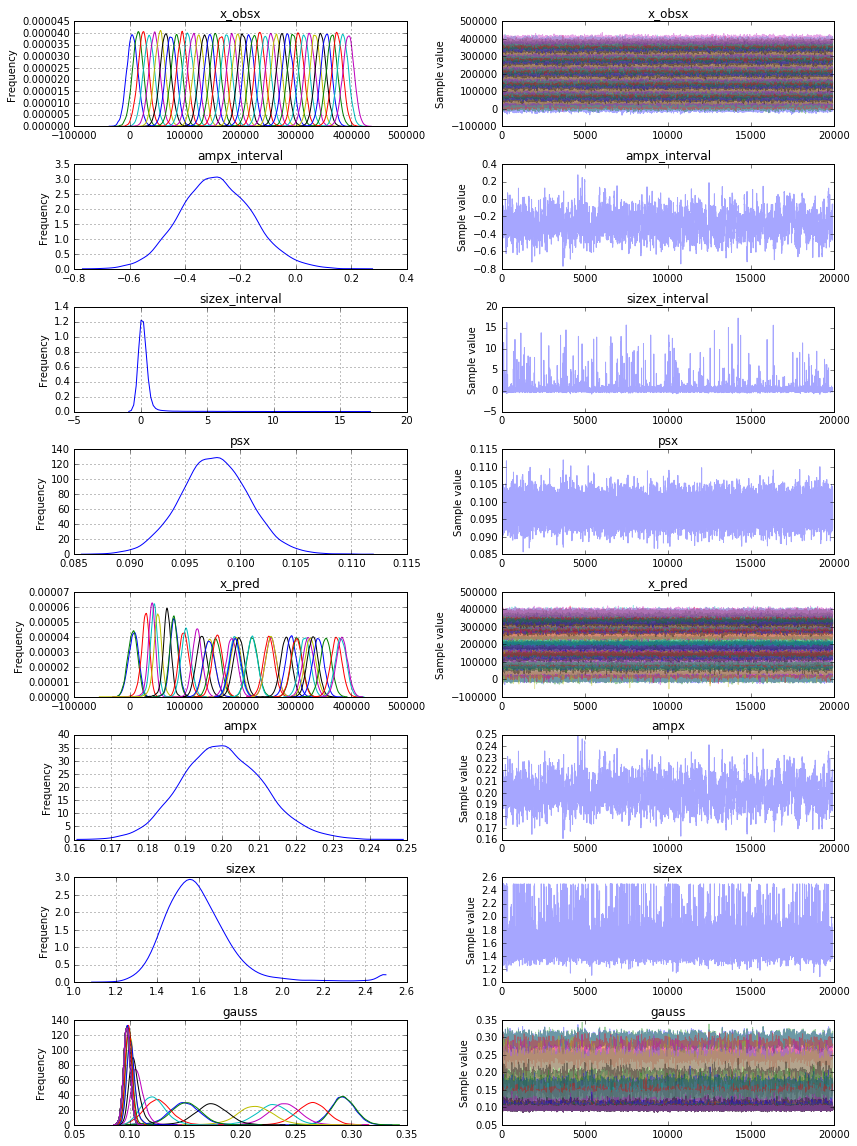

In [25]:
traceplot(tracex[100:])
plt.tight_layout();

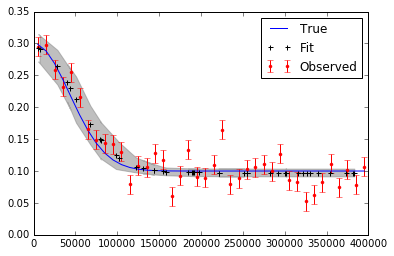

In [26]:
# extract and plot results for PyMC3:
y_minx = np.percentile(tracex.gauss,2.5,axis=0)
y_maxx = np.percentile(tracex.gauss,97.5,axis=0)
y_fitx = np.percentile(tracex.gauss,50,axis=0)
x_fitx=tracex.x_pred.mean(axis=0)
plt.plot(x,f_true,'b', marker='None', ls='-', lw=1, label='True')
plt.errorbar(x,f,yerr=f_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fitx,y_fitx,'k', marker='+', ls='None', ms=5, mew=1, label='Fit')
plt.fill_between(x_fitx, y_minx, y_maxx, color='0.5', alpha=0.5)
plt.legend()

We can see that although the `ampx` and `psx` estimate distributions are centred quite close to their true values, the true value of size (1.8) lies outside of the `sizex` 50% HPD interval, but inside the 95% interval. This is also illustrated in the traceplot above.

In [44]:
summary(tracex, vars=['ampx','psx','sizex'])


ampx:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.200            0.013            0.001            [0.178, 0.222]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.179          0.192          0.200          0.208          0.223


psx:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.098            0.003            0.000            [0.092, 0.104]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.092          0.096          0.098          0.100          0.104


sizex:

  Mean             SD               MC Error         95% HPD interval
  ----------------------------